In [28]:
import torch
import torch.nn as nn
from torch.nn import functional as F
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)
block_size = 8
batch_size = 4

mps


In [29]:
# train a transformer, bigram language model on this txt file
'''
A bigram language model is a type of statistical language model that predicts the probability of a word in a sequence based
on the previous word. It considers pairs of consecutive words (bigrams) and estimates the likelihood of encountering
a specific word given the preceding word in a text or sentence.

A transformer model is a neural network that learns context and thus meaning by tracking relationships in sequential
data like the words in this sentence
'''

'\nA bigram language model is a type of statistical language model that predicts the probability of a word in a sequence based\non the previous word. It considers pairs of consecutive words (bigrams) and estimates the likelihood of encountering\na specific word given the preceding word in a text or sentence.\n\nA transformer model is a neural network that learns context and thus meaning by tracking relationships in sequential\ndata like the words in this sentence\n'

In [30]:
with open('wizard_of_oz.txt', 'r', encoding='utf-8') as f:
    text = f.read()
chars = sorted(set(text)) # all characters in the text feild
print(chars)
print(len(chars))

vocab_size = len(chars)
# we're gonna use a tokenizer
# enocder -> each element of the chars array into an integer

['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\ufeff']
81


In [31]:
string_to_int = {ch:i for i, ch in enumerate(chars)}
int_to_string = {i:ch for i, ch in enumerate(chars)}

encode = lambda s : [string_to_int[c] for c in s]
decode = lambda l: ''.join(int_to_string[i] for i in l)

# encode('hello hi')
# decode(encode('hello hi'))

data = torch.tensor(encode(text), dtype=torch.long) # long seq of integers

len(data)


232325

In [32]:
encoded = encode(text)

# small vocab but lot of characters to work with
# being efficient with data is important

In [33]:
decode(encoded)

'\ufeff  DOROTHY AND THE WIZARD IN OZ\n\n  BY\n\n  L. FRANK BAUM\n\n  AUTHOR OF THE WIZARD OF OZ, THE LAND OF OZ, OZMA OF OZ, ETC.\n\n  ILLUSTRATED BY JOHN R. NEILL\n\n  BOOKS OF WONDER WILLIAM MORROW & CO., INC. NEW YORK\n\n\n  [Illustration]\n\n\n  COPYRIGHT 1908 BY L. FRANK BAUM\n\n  ALL RIGHTS RESERVED\n\n\n         *       *       *       *       *\n\n\n  [Illustration]\n\n\n  DEDICATED TO HARRIET A. B. NEAL.\n\n\n         *       *       *       *       *\n\n\nTo My Readers\n\n\nIt\'s no use; no use at all. The children won\'t let me stop telling tales\nof the Land of Oz. I know lots of other stories, and I hope to tell\nthem, some time or another; but just now my loving tyrants won\'t allow\nme. They cry: "Oz--Oz! more about Oz, Mr. Baum!" and what can I do but\nobey their commands?\n\nThis is Our Book--mine and the children\'s. For they have flooded me with\nthousands of suggestions in regard to it, and I have honestly tried to\nadopt as many of these suggestions as could be fi

In [34]:
data[:100]

tensor([80,  1,  1, 28, 39, 42, 39, 44, 32, 49,  1, 25, 38, 28,  1, 44, 32, 29,
         1, 47, 33, 50, 25, 42, 28,  1, 33, 38,  1, 39, 50,  0,  0,  1,  1, 26,
        49,  0,  0,  1,  1, 36, 11,  1, 30, 42, 25, 38, 35,  1, 26, 25, 45, 37,
         0,  0,  1,  1, 25, 45, 44, 32, 39, 42,  1, 39, 30,  1, 44, 32, 29,  1,
        47, 33, 50, 25, 42, 28,  1, 39, 30,  1, 39, 50,  9,  1, 44, 32, 29,  1,
        36, 25, 38, 28,  1, 39, 30,  1, 39, 50])

In [35]:
'''block_size = 8

x = train_data[:block_size]
y = train_data[1:block_size+1]

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f'When context is {context}, target is {target}')'''

"block_size = 8\n\nx = train_data[:block_size]\ny = train_data[1:block_size+1]\n\nfor t in range(block_size):\n    context = x[:t+1]\n    target = y[t]\n    print(f'When context is {context}, target is {target}')"

In [36]:
# validation and training splits

n = int(0.8 * len(data))

train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    # random index between 0 and len of data - block size, to start generating from
    ix = torch.randint(len(data) - block_size, (batch_size,))
    print(ix)
    #  stack, stacks the blocls together == to the batch size ie 4 in our case
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

get_batch('train')

tensor([ 57249, 138537, 171899,  81221])


(tensor([[ 1, 73, 61, 58, 66, 72, 58, 65],
         [ 3,  0,  0,  3, 26, 74, 73,  1],
         [58,  1, 43, 54, 76, 61, 68, 71],
         [54, 57,  9,  3,  1, 68, 55, 72]], device='mps:0'),
 tensor([[73, 61, 58, 66, 72, 58, 65, 75],
         [ 0,  0,  3, 26, 74, 73,  1, 61],
         [ 1, 43, 54, 76, 61, 68, 71, 72],
         [57,  9,  3,  1, 68, 55, 72, 58]], device='mps:0'))

## sample Probability distribution table
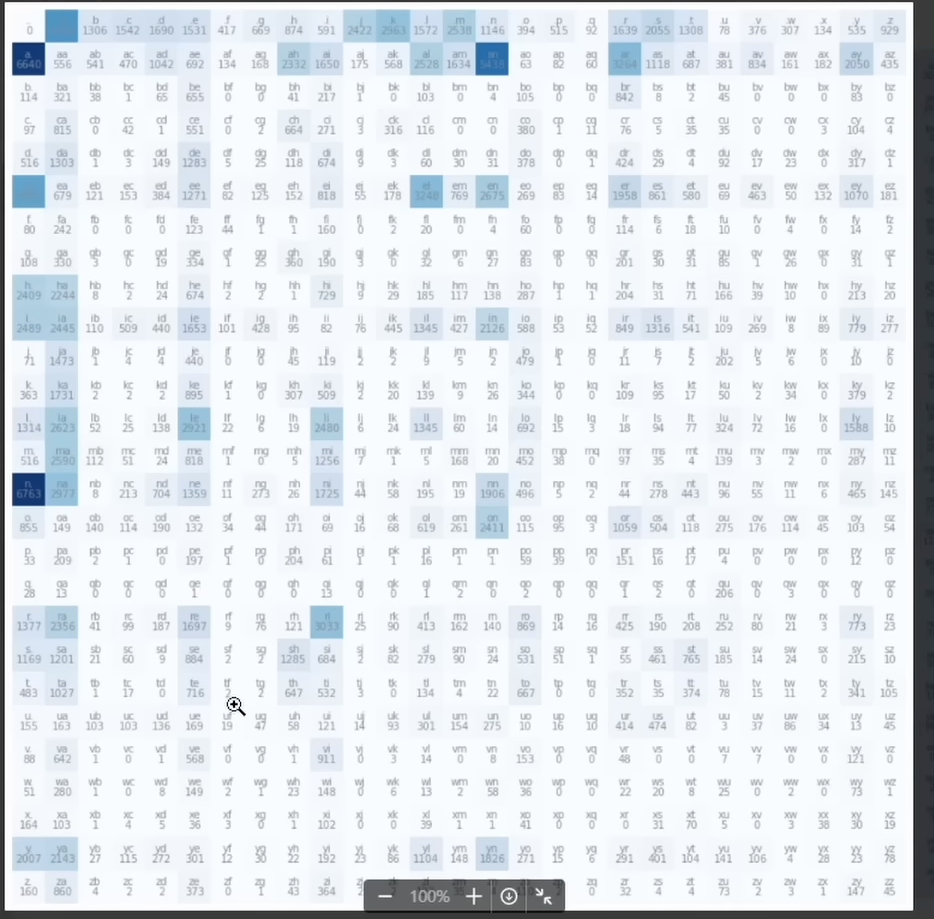

In [37]:
class BigramLanguageModel(nn.Module):
    # it is a subclass of nn.module, inherits
    def __init__(self, vocab_size):
        # to call the constructor of its parent class.
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward_pass(self, index, targets):
        logits = self.token_embedding_table(index)

        return logits

SyntaxError: incomplete input (2073275880.py, line 9)